## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score,max_error,mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

## Choose descriptors

In [2]:
quant_func="median" # median or mean

X_raw=pd.read_excel("/kaggle/input/log-transformed-prot-vs-rna/Inter-cluster_points_log_imputated.xlsx")
X_raw[['cellType', 'batchNum']] = X_raw[X_raw.columns[0]].str.split('-', expand=True)
X_raw = X_raw.drop(columns=[X_raw.columns[0]])
batch_raw=X_raw['batchNum']
cellType_raw=X_raw['cellType']
y_raw=X_raw["y_"+quant_func]
y_raw.columns=["Proteins"]
X_raw=X_raw[["Gene", "x_"+quant_func]]
X_raw.columns=["Gene", "Transcripts"]
display(X_raw)
display(y_raw)
display(batch_raw)
display(cellType_raw)

Gene  Transcripts
0      CLEC12A     0.334289
1      CLEC12A     0.009150
2      CLEC12A     0.050267
3      CLEC12A     0.014250
4      CLEC12A     0.009068
...        ...          ...
10093    ICAM1     0.043033
10094    ICAM1     0.005941
10095    ICAM1     0.226442
10096    ICAM1     0.351083
10097    ICAM1     0.085633

[10098 rows x 2 columns]

0        4.060443
1        1.098612
2        1.609438
3        1.098612
4        1.098612
           ...   
10093    2.397895
10094    1.791759
10095    2.705823
10096    3.481122
10097    2.944439
Name: y_median, Length: 10098, dtype: float64

0        b1
1        b1
2        b1
3        b1
4        b1
         ..
10093    b3
10094    b3
10095    b3
10096    b3
10097    b3
Name: batchNum, Length: 10098, dtype: object

0              CD14_mono
1                B_naive
2                    RBC
3                NK_16hi
4                 CD8.TE
              ...       
10093               MAIT
10094          CD8.Naive
10095            NK_56hi
10096                pDC
10097    Plasma_cell_IgA
Name: cellType, Length: 10098, dtype: object

## Remove genes with low variance

In [3]:
var_threshold=0.5

high_var_genes=[]

for g in X_raw["Gene"]:
    if((X_raw.loc[X_raw["Gene"]==g,"Transcripts"]>var_threshold).any()):
        high_var_genes.append(g)
        
high_var_genes=list(set(high_var_genes))
print(len(high_var_genes))

high_var_index=(X_raw["Gene"].isin(high_var_genes))
X=X_raw.loc[high_var_index].copy()
y=y_raw.loc[high_var_index].copy()
batch=batch_raw.loc[high_var_index].copy()
cellType=cellType_raw.loc[high_var_index].copy()
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
batch.reset_index(inplace=True, drop=True)
cellType.reset_index(inplace=True, drop=True)
display(X)
display(y)
display(batch)
display(cellType)

65


Gene  Transcripts
0     CLEC12A     0.334289
1     CLEC12A     0.009150
2     CLEC12A     0.050267
3     CLEC12A     0.014250
4     CLEC12A     0.009068
...       ...          ...
4285    IL3RA     0.000651
4286    IL3RA     0.001813
4287    IL3RA     0.000365
4288    IL3RA     0.771555
4289    IL3RA     0.028285

[4290 rows x 2 columns]

0       4.060443
1       1.098612
2       1.609438
3       1.098612
4       1.098612
          ...   
4285    0.693147
4286    0.693147
4287    0.693147
4288    4.016342
4289    0.693147
Name: y_median, Length: 4290, dtype: float64

0       b1
1       b1
2       b1
3       b1
4       b1
        ..
4285    b3
4286    b3
4287    b3
4288    b3
4289    b3
Name: batchNum, Length: 4290, dtype: object

0             CD14_mono
1               B_naive
2                   RBC
3               NK_16hi
4                CD8.TE
             ...       
4285               MAIT
4286          CD8.Naive
4287            NK_56hi
4288                pDC
4289    Plasma_cell_IgA
Name: cellType, Length: 4290, dtype: object

In [4]:
def orgMyPlots(subPlotsCount, columns=3):
    rows=np.ceil(float(subPlotsCount)/columns)
    x_ind=[]
    y_ind=[]
    
    for i in range(subPlotsCount):
        x_ind.append(i%columns)
        y_ind.append(int(np.floor(i/columns)))
    return x_ind, y_ind

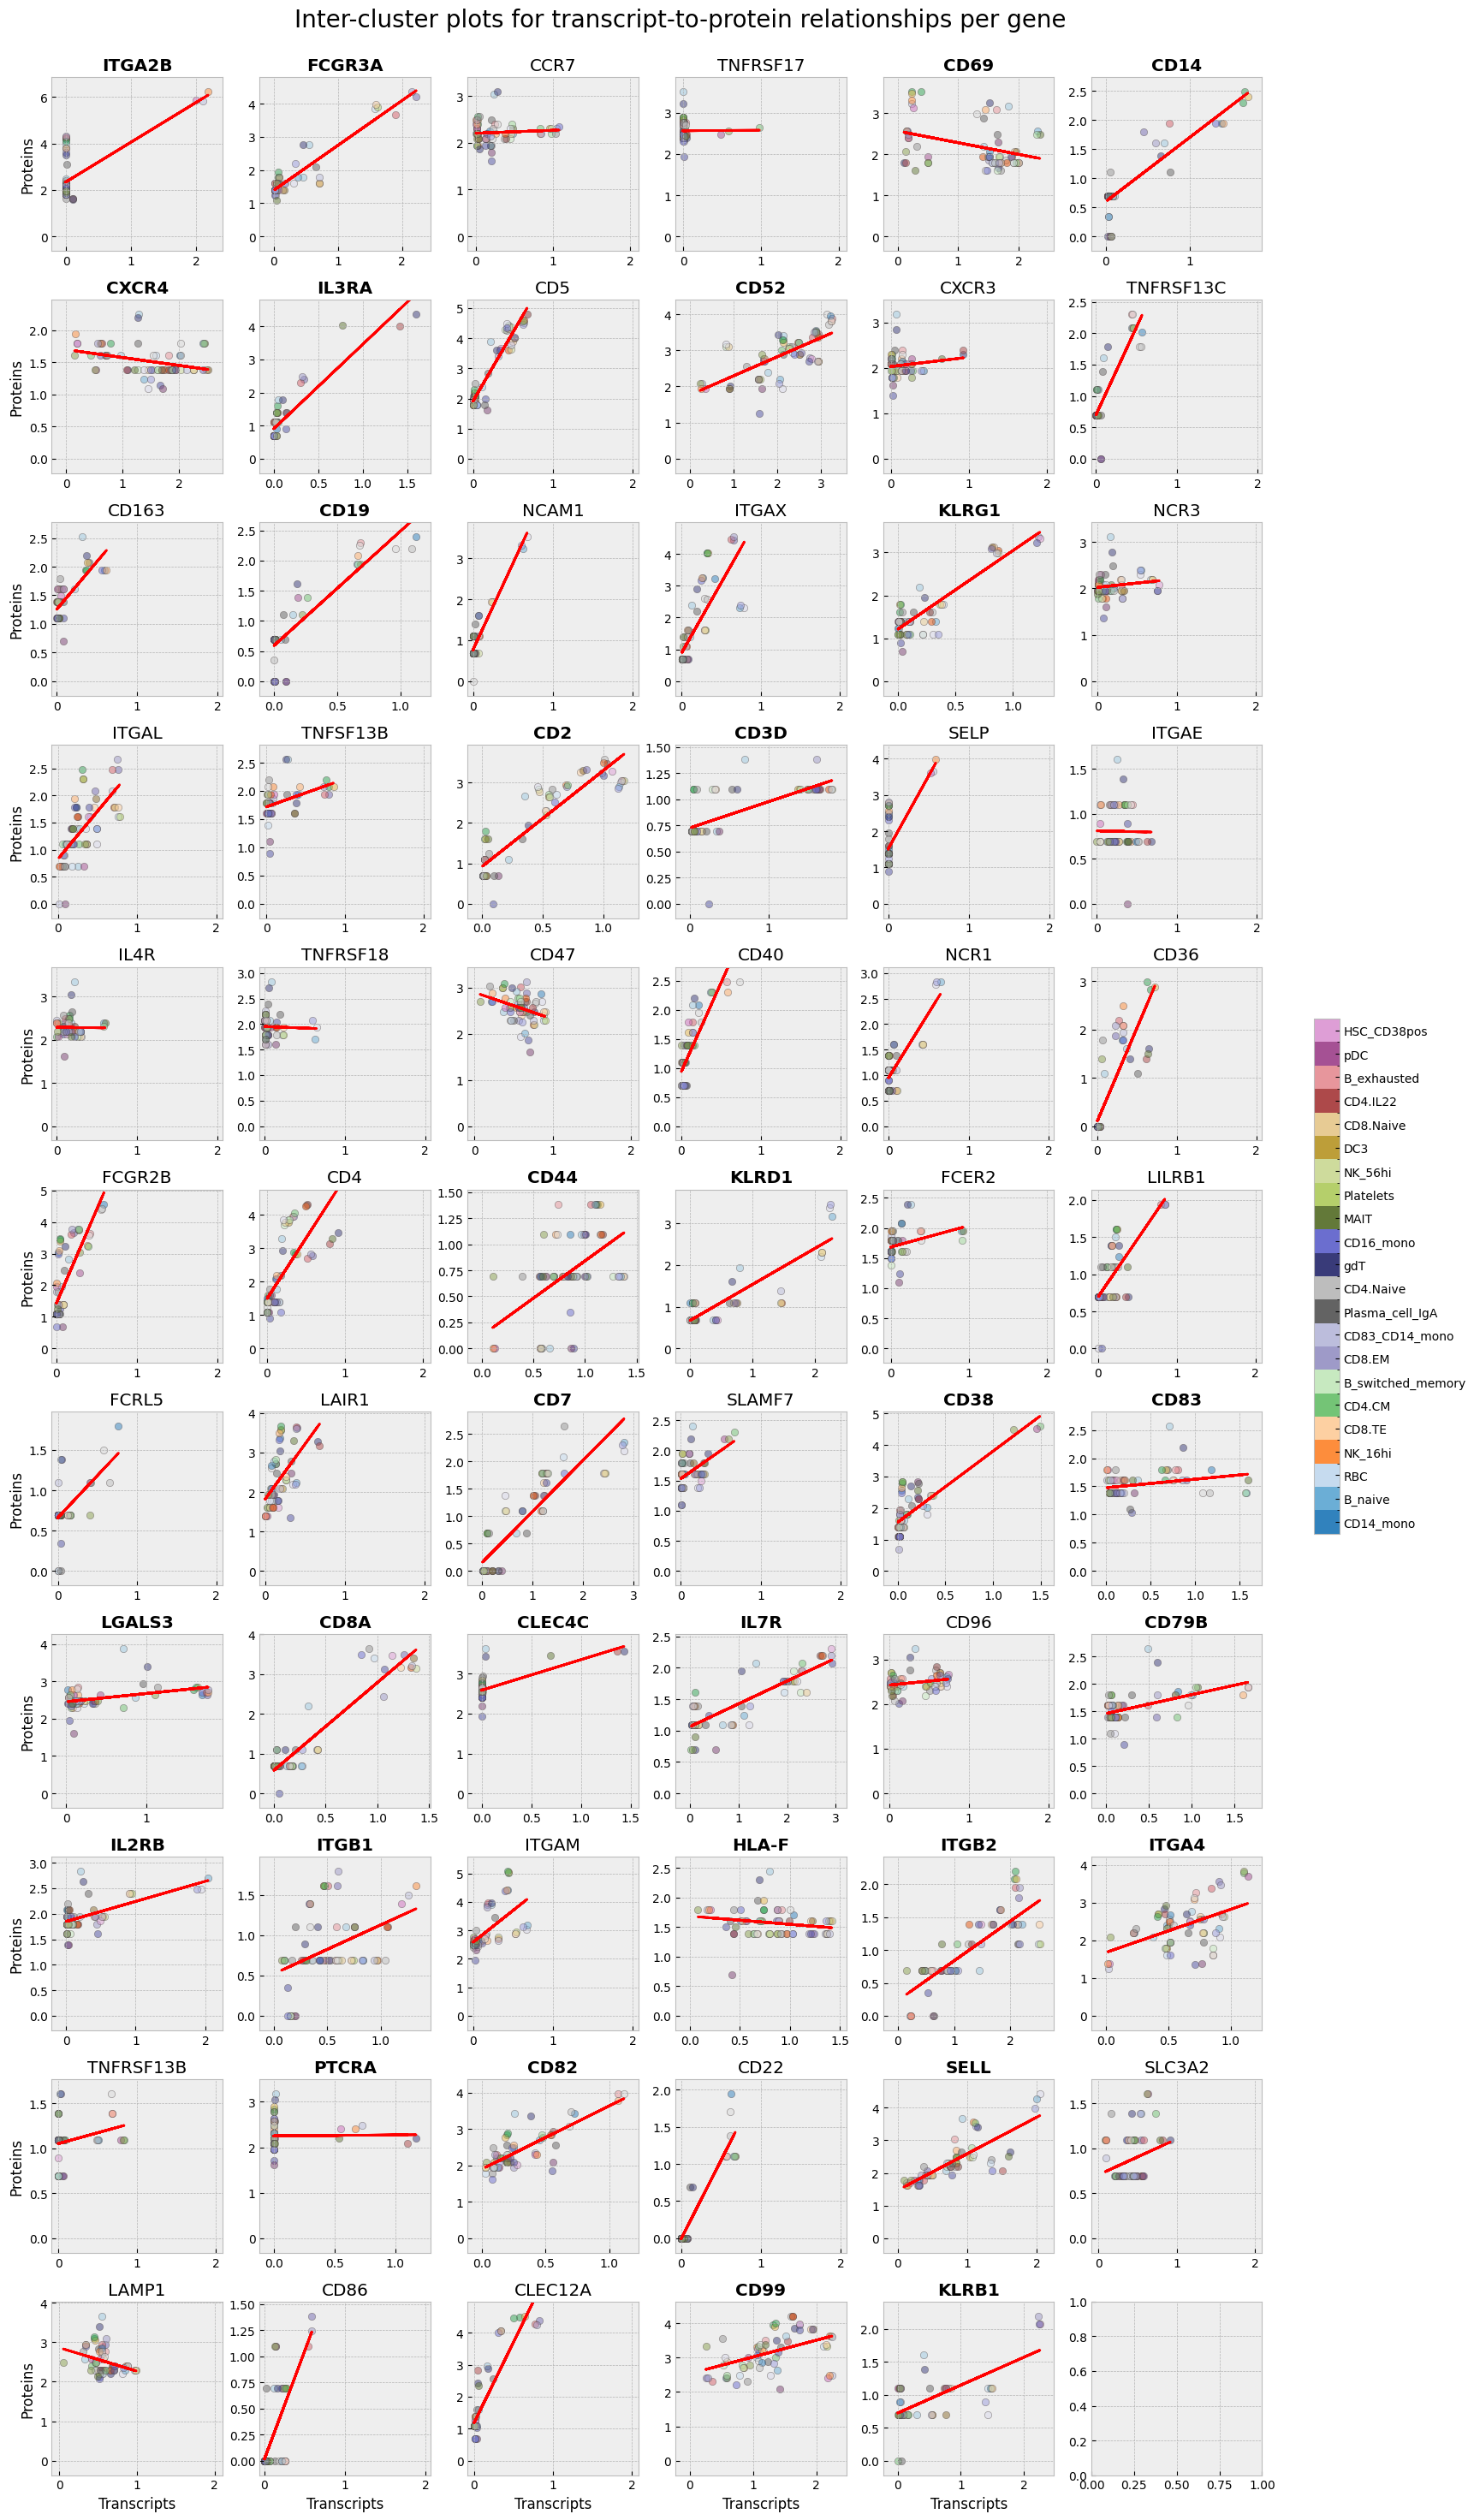

In [46]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Assuming you have already defined your variables like `high_var_genes`, `cellType`, etc.

x_ind, y_ind = orgMyPlots(len(high_var_genes), 6)
plt.style.use('bmh')
fig, ax = plt.subplots(nrows=np.max(y_ind)+1, ncols=np.max(x_ind)+1, figsize=(16, 6*np.array(x_ind).max()))
r_vals = []
p_vals = []
slopes = []
intercepts = []
max_transcripts = []

# Create a combined colormap
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
colors_tab20b = tab20b(np.arange(tab20b.N))
colors_tab20c = tab20c(np.arange(tab20c.N))
combined_colors = np.vstack((colors_tab20c, colors_tab20b))

# Create a ListedColormap and BoundaryNorm for discrete colorbar
listed_cmap = mcolors.ListedColormap(combined_colors)
boundaries = np.arange(len(cellTypes)+1) - 0.5
norm = mcolors.BoundaryNorm(boundaries, listed_cmap.N, clip=True)

# Create a ScalarMappable object for colorbar
sm = plt.cm.ScalarMappable(cmap=listed_cmap, norm=norm)

for j, prot in enumerate(high_var_genes):
    gene_indicies = X["Gene"] == prot
    points = pd.concat({"x": X.loc[gene_indicies, "Transcripts"], "y": y.loc[gene_indicies]}, axis=1)
    points.dropna(inplace=True, how='any', axis=0)
    points.reset_index(inplace=True, drop=True)
    try:
        res = stats.linregress(points['x'], points['y'])
        slopes.append(res.slope)
        intercepts.append(res.intercept)
        r_vals.append(res.rvalue)
        p_vals.append(res.pvalue)
    except:
        slopes.append(np.nan)
        intercepts.append(np.nan)
        r_vals.append(np.nan)
        p_vals.append(np.nan)
        
    if y_ind[j] == np.max(y_ind):
        ax[y_ind[j], x_ind[j]].set_xlabel("Transcripts")
    if x_ind[j] == 0:
        ax[y_ind[j], x_ind[j]].set_ylabel("Proteins")
        
    if points['x'].max() > np.log1p(2):
        ax[y_ind[j], x_ind[j]].set_title(prot, fontweight='bold')
        max_x = points['x'].max()
    else:
        ax[y_ind[j], x_ind[j]].set_title(prot)
        max_x = 2
        
    try:
        paddingx = points['x'].max()/10
        paddingy = points['y'].max()/10
        ax[y_ind[j], x_ind[j]].set_xlim(0-paddingx, max_x+paddingx)
        ax[y_ind[j], x_ind[j]].set_ylim(0-paddingy, points['y'].max()+paddingy)
    except:
        pass
    
    for i, txt in enumerate(points.index):
        ax[y_ind[j], x_ind[j]].scatter(points['x'].values[i], points['y'].values[i], alpha=0.5, color=combined_colors[i % len(combined_colors)], edgecolors='#4a4141')
    ax[y_ind[j], x_ind[j]].plot(points['x'].values, res.intercept + res.slope * points['x'], c='r')
    max_transcripts.append(points['x'].max())
        
fig.suptitle("Inter-cluster plots for transcript-to-protein relationships per gene", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Add discrete colorbar
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_ticks(np.arange(len(cellTypes)))
cbar.set_ticklabels(cellTypes)
plt.show()
fig.savefig("Inter-cluster_by_cell_type.png")

# Save regression results if needed
# regressResults = pd.DataFrame({"Gene": high_var_genes, "Slope": slopes, "Intercept": intercepts, "R-Value": r_vals, "P-Value": p_vals, "Max_Transcripts": max_transcripts})
# regressResults.to_excel("Regression_Results.xlsx")


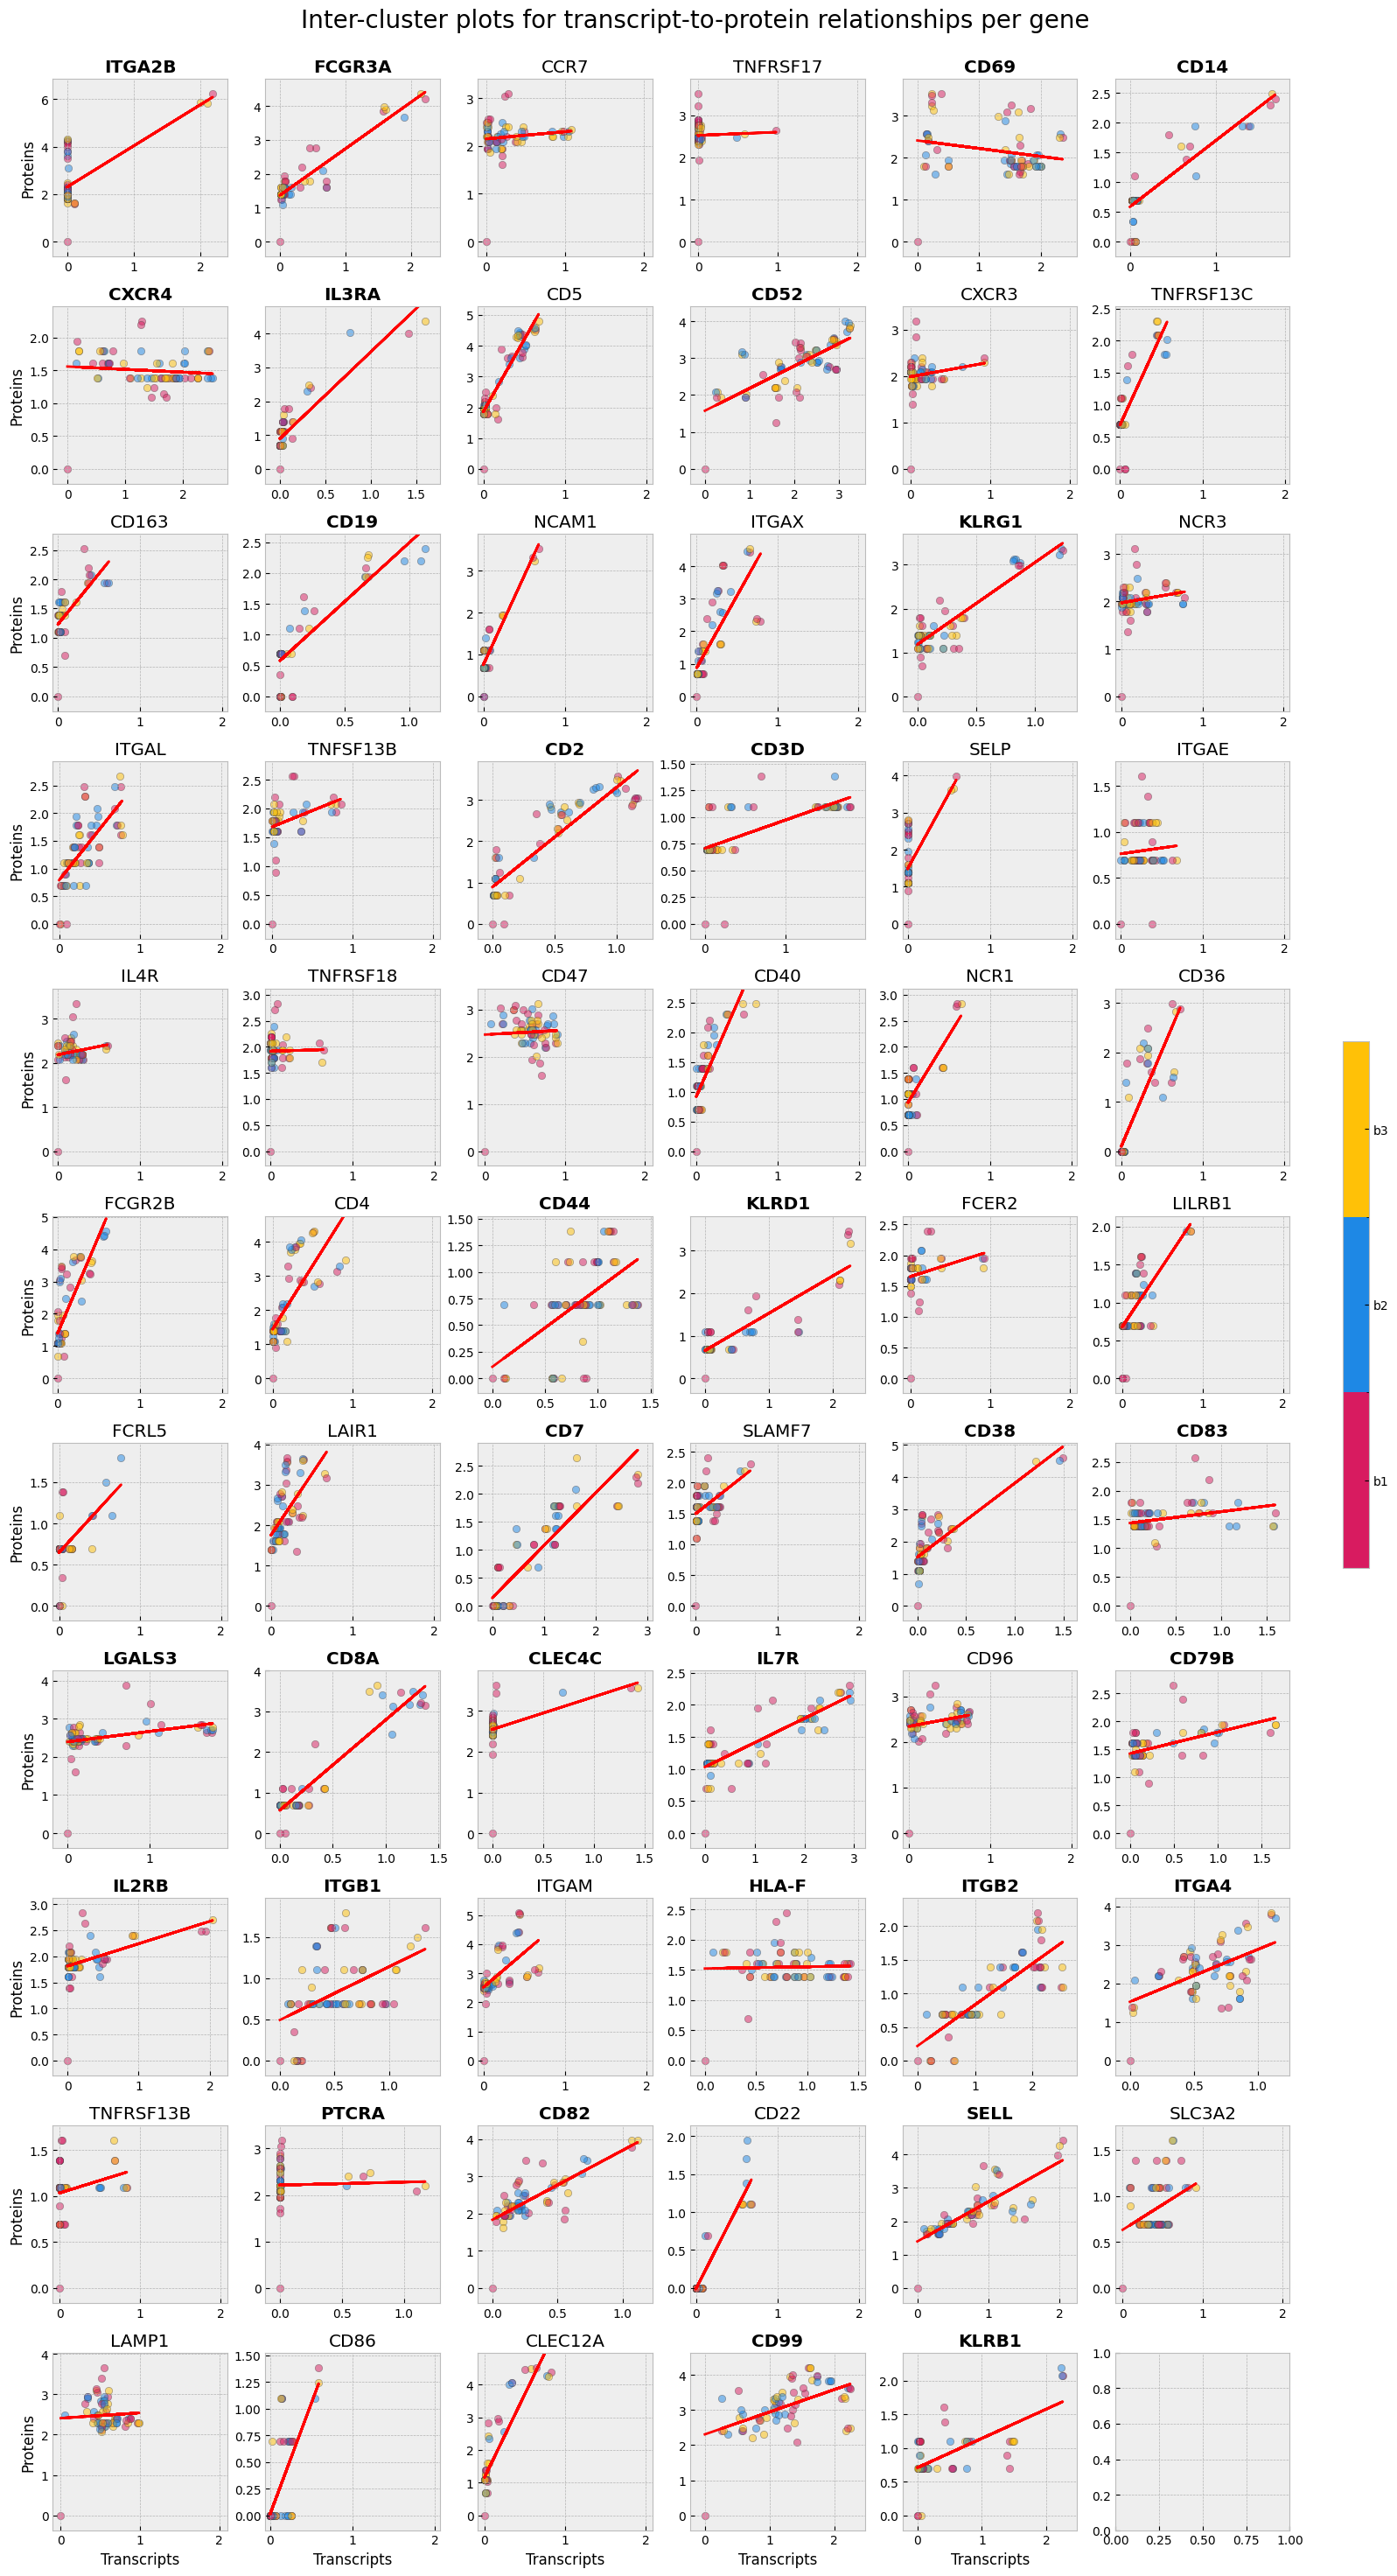

In [40]:
import matplotlib.colors as mcolors
x_ind, y_ind=orgMyPlots(len(high_var_genes),6)
plt.style.use('bmh')
fig, ax = plt.subplots(nrows=np.max(y_ind)+1, ncols=np.max(x_ind)+1, figsize=(16, 6*np.array(x_ind).max()))
r_vals=[]
p_vals=[]
slopes=[]
intercepts=[]
max_transcripts=[]
# Create a colormap
batches = batch.unique()

#cmap = plt.get_cmap('tab10')
#colors = cmap(np.linspace(0, 1, len(batches)))  # Get an array of colors
color_map = {b: colors[i] for i, b in enumerate(batches)}
colors = ['#D81B60', '#1E88E5', '#FFC107']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[0, 1, 2, 3], ncolors=len(colors))
# Create a ScalarMappable object for colorbar
#norm = mcolors.Normalize(vmin=0, vmax=len(batches)-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for j, prot in enumerate(high_var_genes):
    gene_indicies=X["Gene"]==prot
    points=pd.concat({"x": X.loc[gene_indicies, "Transcripts"], "y": y.loc[gene_indicies]}, axis=1)
    points.dropna(inplace=True,how='any',axis=0)
    zeros=pd.DataFrame([{'x':0, 'y':0}])
    points=pd.concat([points,zeros], axis=0)
    points.reset_index(inplace=True, drop=True)
    try:
        res=stats.linregress(points['x'], points['y'])
        slopes.append(res.slope)
        intercepts.append(res.intercept)
        r_vals.append(res.rvalue)
        p_vals.append(res.pvalue)
        
    except:
        slopes.append(np.nan)
        intercepts.append(np.nan)
        r_vals.append(np.nan)
        p_vals.append(np.nan)
    if(y_ind[j]==np.max(y_ind)):
        ax[y_ind[j],x_ind[j]].set_xlabel("Transcripts")
    if(x_ind[j]==0):
        ax[y_ind[j],x_ind[j]].set_ylabel("Proteins")
        
        
    if(points['x'].max()>np.log1p(2)):
        ax[y_ind[j],x_ind[j]].set_title(prot, fontweight='bold')
        max_x=points['x'].max()
    else:
        ax[y_ind[j],x_ind[j]].set_title(prot)
        max_x=2
        
    try:
        paddingx=points['x'].max()/10
        paddingy=points['y'].max()/10
        ax[y_ind[j],x_ind[j]].set_xlim(0-paddingx,max_x+paddingx)
        ax[y_ind[j],x_ind[j]].set_ylim(0-paddingy,points['y'].max()+paddingy)
    except:
        pass
    
    for i, txt in enumerate(points.index):
        ax[y_ind[j],x_ind[j]].scatter(points['x'].values[i], points['y'].values[i], alpha=0.5, color=colors[i % len(colors)], edgecolors='#4a4141')
    ax[y_ind[j],x_ind[j]].plot(points['x'].values,res.intercept+res.slope*points['x'], c='r')
    #ax[y_ind[j],x_ind[j]].scatter(0, 0, alpha=1, color='r')
    max_transcripts.append(points['x'].max())
        
#fig.colorbar()
fig.suptitle("Inter-cluster plots for transcript-to-protein relationships per gene", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_ticks([0.5, 1.5, 2.5])
cbar.set_ticklabels(batches)
plt.show()
fig.savefig("Inter-cluster_by_batch.png")

#regressResults=pd.DataFrame({"Gene": high_var_genes, "Slope": slopes, "Intercept": intercepts, "R-Value": r_vals, "P-Value": p_vals, "Max_Transcripts": max_transcripts})
#regressResults.to_excel("Regression_Results.xlsx")

In [7]:
!pip install protpy
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.0/373.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.0 MB/s eta 0:00:0000:0100:01


In [8]:
from Bio import SeqIO
import protpy as protpy
import numpy as np

def get_fasta(geneList):
    gene_to_seq = {}
    sequences=[]
    geneList=list(geneList)
    successfulGenes=[]

    for record in SeqIO.parse("/kaggle/input/uniprot-swissprot-fasta/uniprot_sprot.fasta", "fasta"):
        org=record.name.split("|")[2].split("_")[1]
        try:
            gene=record.description.split("GN=")[1].split(" ")[0]
        except Exception as e:
            print(e)
            gene=record.name.split("|")[2].split("_")[0]
        if(org == "HUMAN" and gene in geneList):
            gene_to_seq[gene]=record.seq
            #print(gene_to_seq)
    for gene in geneList:
        try:
            new_seq=gene_to_seq[gene]
            sequences.append(new_seq)
            successfulGenes.append(gene)
        except Exception as e:
            print(e)
    return sequences, successfulGenes

prots=X["Gene"].unique()
seqs, genes_found=get_fasta(prots) # use genes in common between surface markers and dataset
desc_lookup=pd.DataFrame({"Gene": genes_found, "FASTA": seqs})
descList=[]
for seq in seqs:
    descList.append(protpy.dipeptide_composition(str(seq)))
desc_lookup=desc_lookup.join(pd.DataFrame(np.squeeze(descList)))
desc_lookup.drop("FASTA", inplace=True, axis=1)
desc_lookup.set_index("Gene", inplace=True)
display(desc_lookup)

list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out of range
list index out o

0     1     2     3     4     5     6     7     8     9    ...  \
Gene                                                                   ...   
CLEC12A    0.76  0.38  0.38  0.00  0.00  0.00  0.00  0.00  0.00  0.76  ...   
CD8A       1.71  0.85  0.00  0.43  0.00  0.85  0.00  0.00  0.43  1.71  ...   
PTCRA      0.36  0.00  0.00  0.36  0.71  1.79  0.36  0.00  0.00  2.14  ...   
LGALS3     0.00  0.00  0.40  0.00  0.40  1.20  0.40  0.00  0.00  0.80  ...   
KLRD1      0.00  0.00  0.00  0.00  0.56  0.00  0.00  0.00  0.00  1.12  ...   
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
TNFRSF13C  0.55  0.55  0.00  1.09  0.00  2.19  0.00  0.00  0.00  2.73  ...   
CD96       0.17  0.00  0.17  0.00  0.17  0.17  0.00  0.00  0.17  0.51  ...   
CD82       0.00  0.38  0.38  0.38  0.38  0.38  0.00  0.38  0.00  0.38  ...   
SLAMF7     0.90  0.00  0.30  0.00  0.00  0.30  0.00  0.00  0.00  0.30  ...   
IL3RA      0.27  0.00  0.53  0.27  0.27  0.80  0.00  0.27  0.53  0.80  ...   

           390   391   392   393   394   395   396   397   398   399  
Gene                                                                  
CLEC12A    0.0  0.00  0.00  0.00  0.00  0.38  0.00  0.38  0.38  0.38  
CD8A       0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.43  0.00  0.43  
PTCRA      0.0  0.00  0.36  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
LGALS3     0.0  0.80  3.61  0.00  0.00  0.00  0.40  0.00  0.00  0.00  
KLRD1      0.0  0.56  0.00  0.00  0.56  0.56  0.00  0.00  0.56  0.00  
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
TNFRSF13C  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
CD96       0.0  0.17  0.51  0.17  0.17  0.17  0.17  0.00  0.00  0.17  
CD82       0.0  0.75  0.38  0.38  0.00  0.38  0.00  0.75  0.00  0.00  
SLAMF7     0.0  0.00  0.00  0.00  0.00  0.90  0.30  0.60  0.00  0.30  
IL3RA      0.0  0.00  0.00  0.00  0.00  0.27  0.53  0.00  0.00  0.00  

[65 rows x 400 columns]

In [22]:
import pickle
def get_abundances(transcripts_per_gene_df): # takes a dataframe where indicies are gene names and one column (transcripts)
    #X_desc=desc_lookup.copy()
    X_desc=[]
    geneList=transcripts_per_gene_df["Gene"]
    for gene in geneList:
        X_desc.append(desc_lookup.loc[gene])
    X_desc=pd.DataFrame(X_desc)
    X_desc.reset_index(inplace=True, drop=True)
    display(X_desc)
    X_desc=X_desc.mul(transcripts_per_gene_df["Transcripts"], axis=0)
    #transcripts_per_gene_df=transcripts_per_gene_df.to_frame()
    X=transcripts_per_gene_df.join(X_desc, how='inner') # based on index
    X.drop("Gene", inplace=True, axis=1)
    X.columns = X.columns.astype(str)
    
    # ridge model
    model_file = open("/kaggle/input/protein_abundance_predictor/scikitlearn/ridge/2/Ridge_Protein_Abundance_Predictor.sav",'rb')
    model = pickle.load(model_file)
    model_file.close()
    y_ridge=model.predict(X)
    
    # random forest model
    model_file = open("/kaggle/input/protein_abundance_predictor/scikitlearn/default/1/Protein_Abundance_Predictor.sav",'rb')
    model = pickle.load(model_file)
    model_file.close()
    y_rf=model.predict(X)
    y=pd.DataFrame({"Gene": geneList, "Transcripts":transcripts_per_gene_df["Transcripts"], "Proteins_Ridge": y_ridge, "Proteins_RF": y_rf})
    return y


pred_df=get_abundances(X)
display(pred_df)

0     1     2     3     4    5    6     7     8     9    ...  390  391  \
0     0.76  0.38  0.38  0.00  0.00  0.0  0.0  0.00  0.00  0.76  ...  0.0  0.0   
1     0.76  0.38  0.38  0.00  0.00  0.0  0.0  0.00  0.00  0.76  ...  0.0  0.0   
2     0.76  0.38  0.38  0.00  0.00  0.0  0.0  0.00  0.00  0.76  ...  0.0  0.0   
3     0.76  0.38  0.38  0.00  0.00  0.0  0.0  0.00  0.00  0.76  ...  0.0  0.0   
4     0.76  0.38  0.38  0.00  0.00  0.0  0.0  0.00  0.00  0.76  ...  0.0  0.0   
...    ...   ...   ...   ...   ...  ...  ...   ...   ...   ...  ...  ...  ...   
4285  0.27  0.00  0.53  0.27  0.27  0.8  0.0  0.27  0.53  0.80  ...  0.0  0.0   
4286  0.27  0.00  0.53  0.27  0.27  0.8  0.0  0.27  0.53  0.80  ...  0.0  0.0   
4287  0.27  0.00  0.53  0.27  0.27  0.8  0.0  0.27  0.53  0.80  ...  0.0  0.0   
4288  0.27  0.00  0.53  0.27  0.27  0.8  0.0  0.27  0.53  0.80  ...  0.0  0.0   
4289  0.27  0.00  0.53  0.27  0.27  0.8  0.0  0.27  0.53  0.80  ...  0.0  0.0   

      392  393  394   395   396   397   398   399  
0     0.0  0.0  0.0  0.38  0.00  0.38  0.38  0.38  
1     0.0  0.0  0.0  0.38  0.00  0.38  0.38  0.38  
2     0.0  0.0  0.0  0.38  0.00  0.38  0.38  0.38  
3     0.0  0.0  0.0  0.38  0.00  0.38  0.38  0.38  
4     0.0  0.0  0.0  0.38  0.00  0.38  0.38  0.38  
...   ...  ...  ...   ...   ...   ...   ...   ...  
4285  0.0  0.0  0.0  0.27  0.53  0.00  0.00  0.00  
4286  0.0  0.0  0.0  0.27  0.53  0.00  0.00  0.00  
4287  0.0  0.0  0.0  0.27  0.53  0.00  0.00  0.00  
4288  0.0  0.0  0.0  0.27  0.53  0.00  0.00  0.00  
4289  0.0  0.0  0.0  0.27  0.53  0.00  0.00  0.00  

[4290 rows x 400 columns]

Gene  Transcripts  Proteins_Ridge  Proteins_RF
0     CLEC12A     0.334289        2.446385     2.752744
1     CLEC12A     0.009150        0.066962     1.285474
2     CLEC12A     0.050267        0.367866     1.392006
3     CLEC12A     0.014250        0.104286     1.296530
4     CLEC12A     0.009068        0.066362     1.285474
...       ...          ...             ...          ...
4285    IL3RA     0.000651        0.002293     1.214480
4286    IL3RA     0.001813        0.006390     1.099150
4287    IL3RA     0.000365        0.001288     1.247867
4288    IL3RA     0.771555        2.719903     2.710316
4289    IL3RA     0.028285        0.099712     1.181366

[4290 rows x 4 columns]

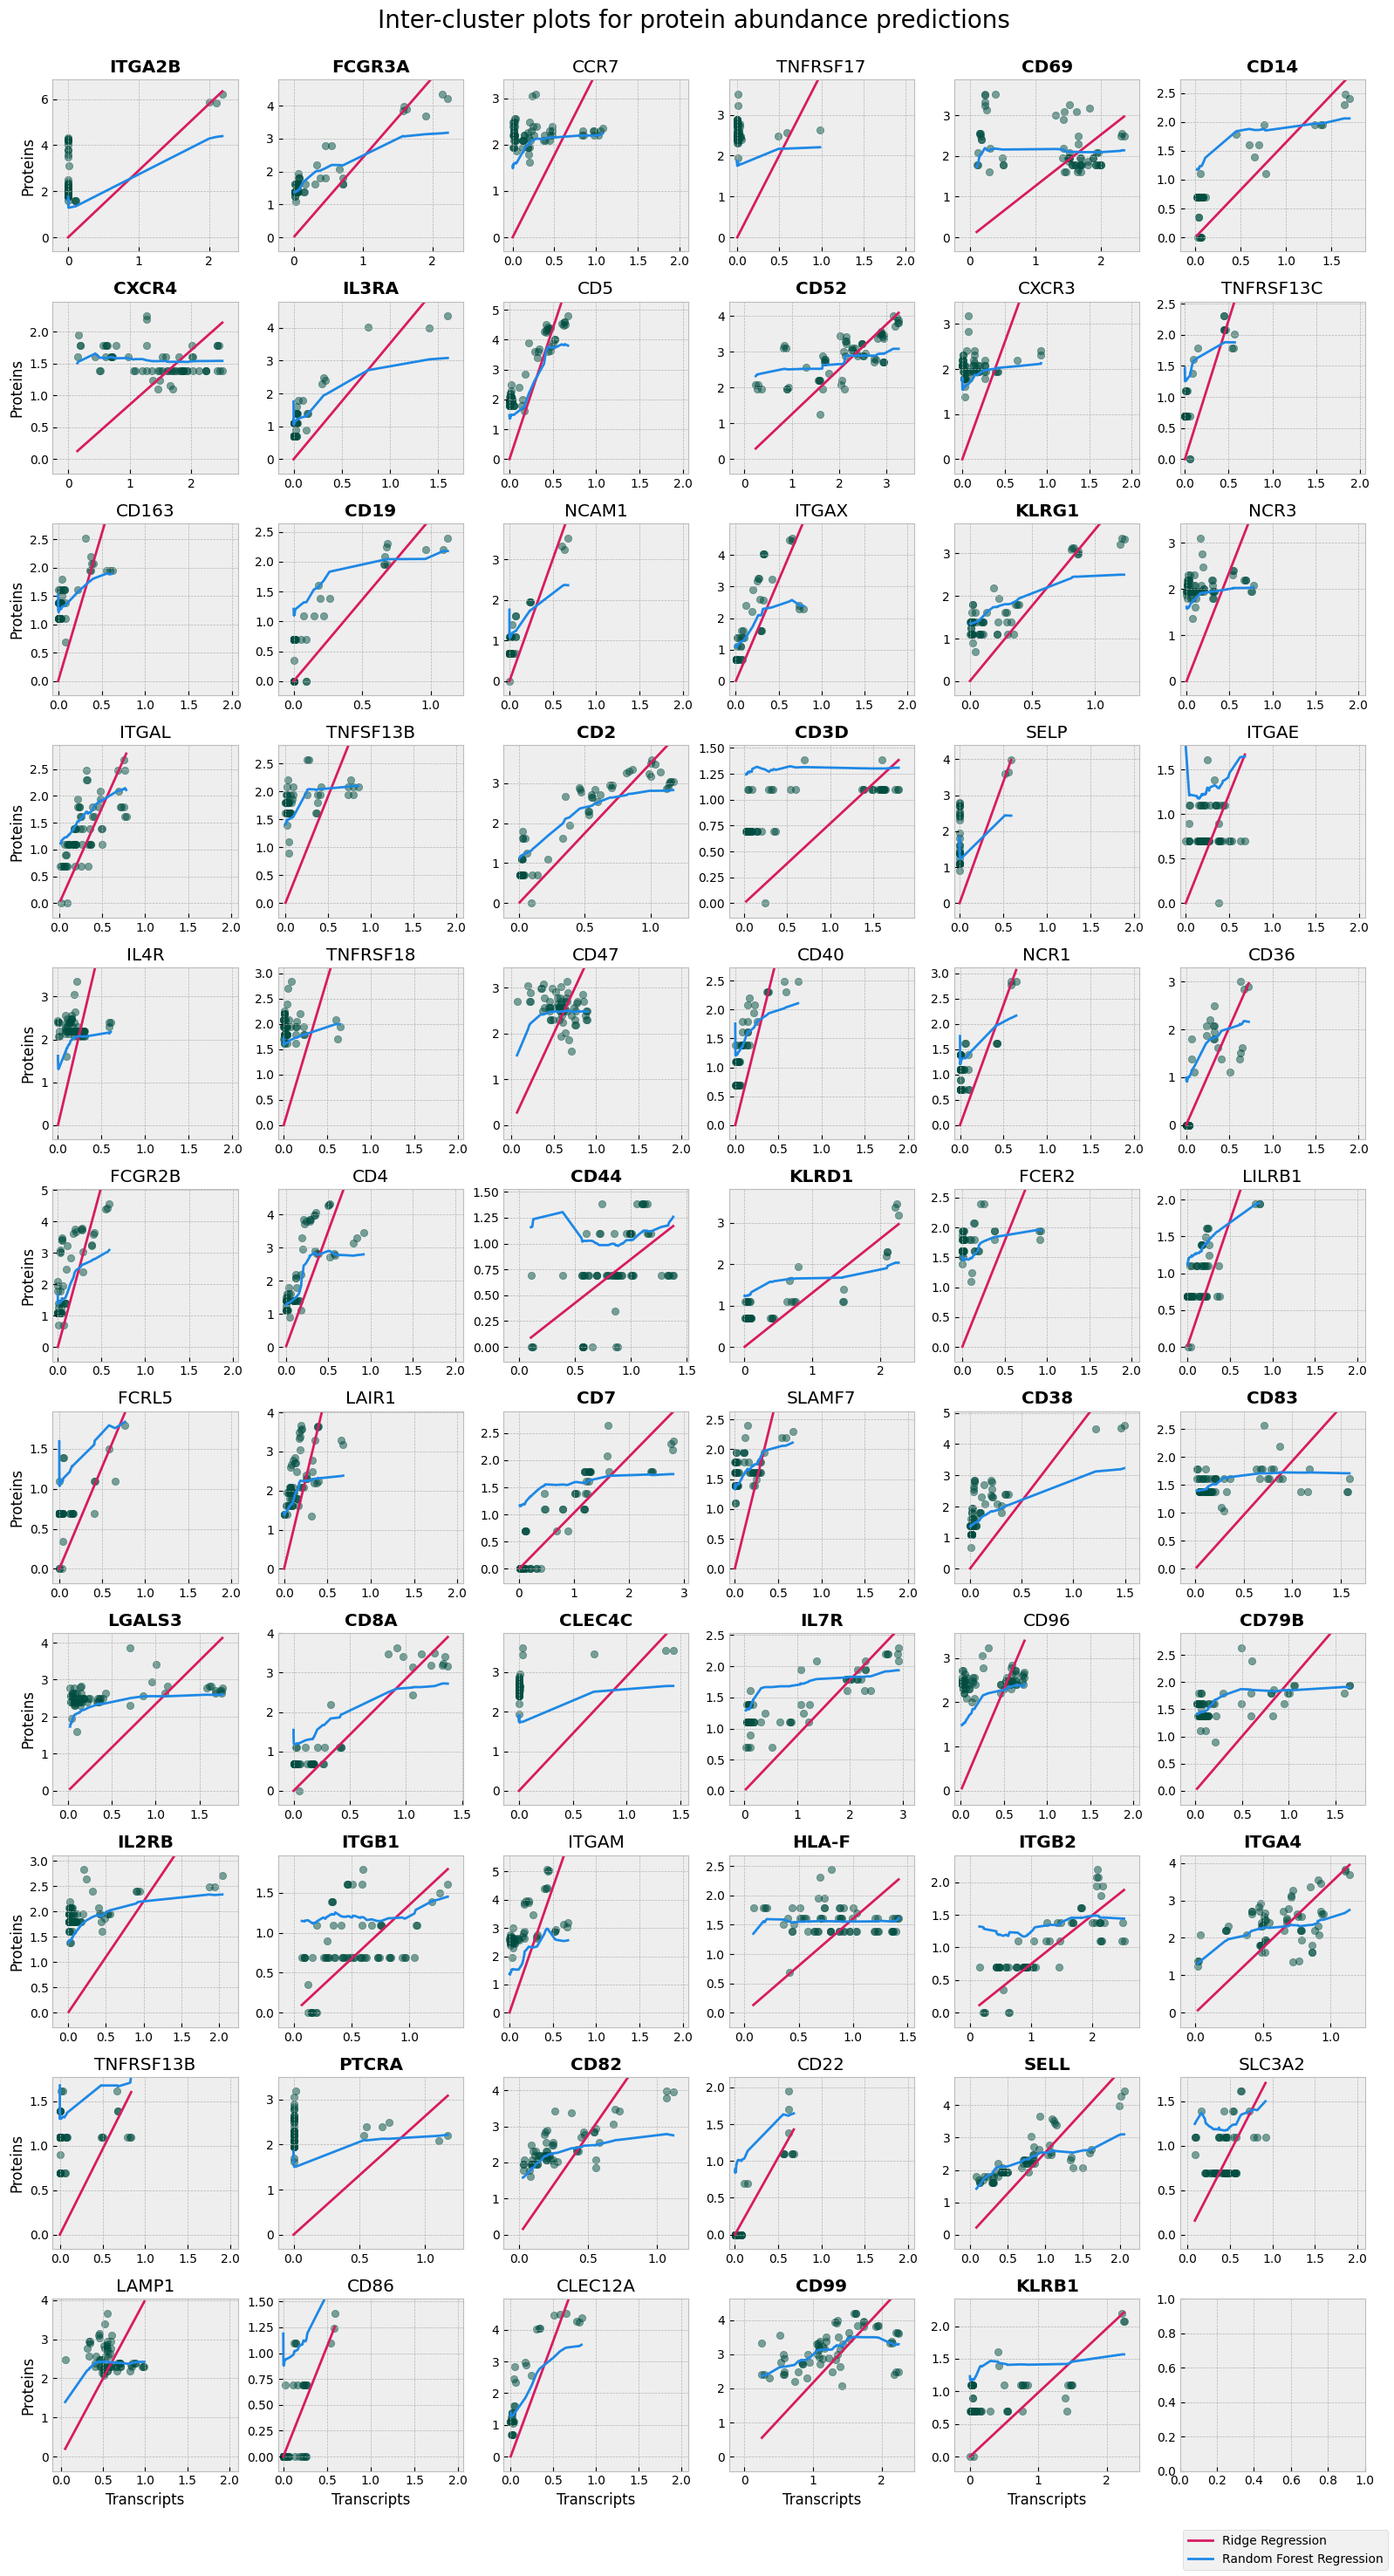

In [35]:
import matplotlib.colors as mcolors
x_ind, y_ind=orgMyPlots(len(high_var_genes),6)
plt.style.use('bmh')
fig, ax = plt.subplots(nrows=np.max(y_ind)+1, ncols=np.max(x_ind)+1, figsize=(16, 6*np.array(x_ind).max()))
r_vals=[]
p_vals=[]
slopes=[]
intercepts=[]
max_transcripts=[]
# Create a colormap
cellTypes = cellType.unique()

for j, prot in enumerate(high_var_genes):
    gene_indicies=X["Gene"]==prot
    points=pd.concat({"x": X.loc[gene_indicies, "Transcripts"], "y": y.loc[gene_indicies]}, axis=1)
    points.dropna(inplace=True,how='any',axis=0)
    pred=pred_df.loc[pred_df["Gene"]==prot, ['Transcripts', 'Proteins_Ridge', 'Proteins_RF']].copy()
    pred.sort_values(inplace=True, ascending=True, by="Transcripts")
    #zeros=pd.DataFrame([{'x':0, 'y':0}])
    #points=pd.concat([points,zeros], axis=0)
    points.reset_index(inplace=True, drop=True)
    if(y_ind[j]==np.max(y_ind)):
        ax[y_ind[j],x_ind[j]].set_xlabel("Transcripts")
    if(x_ind[j]==0):
        ax[y_ind[j],x_ind[j]].set_ylabel("Proteins")
        
        
    if(points['x'].max()>np.log1p(2)):
        ax[y_ind[j],x_ind[j]].set_title(prot, fontweight='bold')
        max_x=points['x'].max()
    else:
        ax[y_ind[j],x_ind[j]].set_title(prot)
        max_x=2
        
    try:
        paddingx=points['x'].max()/10
        paddingy=points['y'].max()/10
        ax[y_ind[j],x_ind[j]].set_xlim(0-paddingx,max_x+paddingx)
        ax[y_ind[j],x_ind[j]].set_ylim(0-paddingy,points['y'].max()+paddingy)
    except:
        pass
    
    for i, txt in enumerate(points.index):
        ax[y_ind[j],x_ind[j]].scatter(points['x'].values[i], points['y'].values[i], alpha=0.5, color='#004D40')
    ax[y_ind[j],x_ind[j]].plot(pred["Transcripts"],pred["Proteins_Ridge"], c='#D81B60', label='Ridge Regression')
    ax[y_ind[j],x_ind[j]].plot(pred["Transcripts"],pred["Proteins_RF"], c='#1E88E5', label='Random Forest Regression')
    #ax[y_ind[j],x_ind[j]].scatter(0, 0, alpha=1, color='r')
    max_transcripts.append(points['x'].max())
        
#fig.colorbar()
fig.suptitle("Inter-cluster plots for protein abundance predictions", fontsize=20)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()
fig.savefig("Inter-cluster_predictions.png")

#regressResults=pd.DataFrame({"Gene": high_var_genes, "Slope": slopes, "Intercept": intercepts, "R-Value": r_vals, "P-Value": p_vals, "Max_Transcripts": max_transcripts})
#regressResults.to_excel("Regression_Results.xlsx")